In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-class-twitter-data/tweet_data.csv
/kaggle/input/lockdown-tweet-dataset/lockdown_tweet_data.csv
/kaggle/input/covid-vaccine-tweet-data/vaccine_tweet_data.csv


# Twitter is a gold mine of data. Unlike other social platforms, almost every user’s tweets are completely public and pullable.
This is a huge plus if you’re trying to get a large amount of data to run analytics on. Twitter data is also pretty specific. 

Twitter’s API allows you to do complex queries like pulling every tweet about a certain topic within the last twenty minutes, or pull a certain user’s non-retweeted tweets.

Importing necessary libraries

In [2]:
# Import libraries
import pandas as pd
from textblob import TextBlob
from pandas.io.json import json_normalize
from wordcloud import WordCloud
import math
import re
import json
import numpy as np
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import spacy
from nltk.corpus import sentiwordnet as swn
from IPython.display import clear_output
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly
plotly.offline.init_notebook_mode (connected = True)

In [3]:
data2=pd.read_csv('../input/covid-vaccine-tweet-data/vaccine_tweet_data.csv')

In [4]:
data2[["tweet"]].head()

,tweet
0,#IndiaFightsCorona: ✅58.89 crore vaccine dose...
1,Joe Biden Urges Private Businesses to ‘Step Up...
2,The flu vaccine for kids was stopped immediate...
3,all the vaccines have terrible product brandin...
4,@Viscous_cree @Zinj @EclecticRadical @kenklipp...


# Text obtained from tweets is not clean enough to be used for model training So it needs to be pre-processed first. 
# We may not be able to make it completely clean but should try our best to pre-process as much as possible.

In [5]:
data2.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [6]:
data2.shape

(9127, 36)

In [7]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               9127 non-null   int64  
 1   conversation_id  9127 non-null   int64  
 2   created_at       9127 non-null   object 
 3   date             9127 non-null   object 
 4   time             9127 non-null   object 
 5   timezone         9127 non-null   int64  
 6   user_id          9127 non-null   int64  
 7   username         9127 non-null   object 
 8   name             9127 non-null   object 
 9   place            2 non-null      object 
 10  tweet            9127 non-null   object 
 11  language         9127 non-null   object 
 12  mentions         9127 non-null   object 
 13  urls             9127 non-null   object 
 14  photos           9127 non-null   object 
 15  replies_count    9127 non-null   int64  
 16  retweets_count   9127 non-null   int64  
 17  likes_count   

In [8]:
data2.dtypes

id                   int64
conversation_id      int64
created_at          object
date                object
time                object
timezone             int64
user_id              int64
username            object
name                object
place               object
tweet               object
language            object
mentions            object
urls                object
photos              object
replies_count        int64
retweets_count       int64
likes_count          int64
hashtags            object
cashtags            object
link                object
retweet               bool
quote_url           object
video                int64
thumbnail           object
near               float64
geo                float64
source             float64
user_rt_id         float64
user_rt            float64
retweet_id         float64
reply_to            object
retweet_date       float64
translate          float64
trans_src          float64
trans_dest         float64
dtype: object

In [9]:
print('Count of columns in the dataset is:  ', len(data2.columns))
print('Count of rows in the dataset is:  ', len(data2))

Count of columns in the dataset is:   36
Count of rows in the dataset is:   9127


In [10]:
np.sum(data2.isnull().any(axis=1))

9127

In [11]:
data2["geo"].value_counts()

Series([], Name: geo, dtype: int64)

In [12]:
data2["language"].value_counts()

en     8247
fr      268
tl      138
in      133
ja      105
und      70
it       22
hi       21
es       18
et       13
ta       11
th        9
de        9
ro        8
zh        7
da        6
tr        5
ht        5
vi        3
ca        3
fi        3
kn        2
sl        2
nl        2
ur        2
ar        2
pt        2
lv        1
sv        1
mr        1
iw        1
ru        1
lt        1
bn        1
el        1
si        1
te        1
hu        1
Name: language, dtype: int64

<AxesSubplot:ylabel='language'>

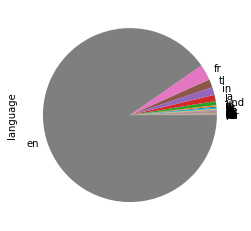

In [13]:
data2.language.value_counts().sort_values().plot(kind = 'pie')

In [14]:
data2["tweet"][0]

'#IndiaFightsCorona:  ✅58.89 crore vaccine doses administered so far  ✅Testing capacity substantially ramped up - 50.93 crore tests conducted so far  #We4Vaccine #LargestVaccinationDrive #Unite2FightCorona   Details:  https://t.co/6kTcmX3APi  https://t.co/fzETtgQ0U9'

In [15]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [16]:
hashtags = hashtag_extract(data2["tweet"])
hashtags = sum(hashtags, [])

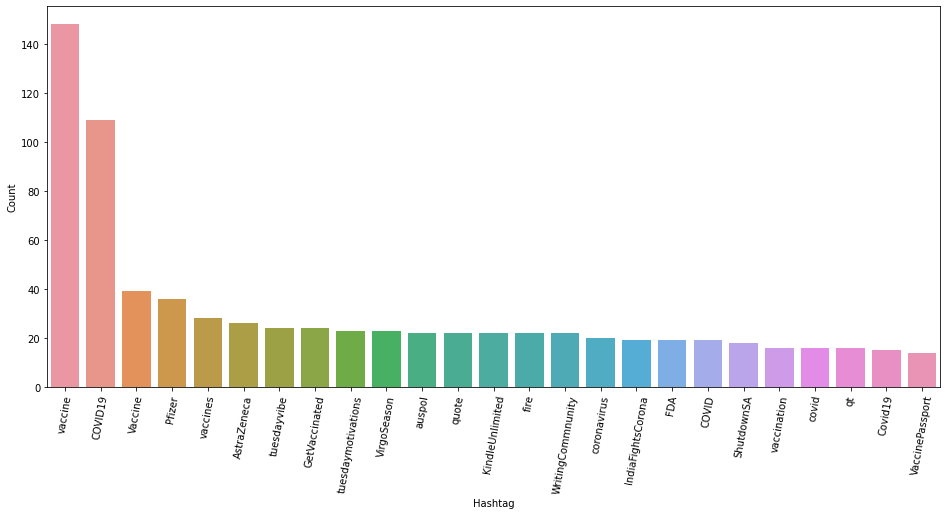

In [17]:
generate_hashtag_freqdist(hashtags)

# We also remove Stop Words

Stop words are the words in that are used just for the sake of correct sentence formations. 
They don’t have any meaning full information. So it needs to be removed to make our text record cleaner.

In [18]:
# Preprocessing functions
"""
Removing ‘@names’,links (http | https),Punctuations, Numbers and Special characters. Because they don't convey any sentiment of the text

"""

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# Basic function to clean the text
def clean_tweet(text):
    text = str(text)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove identifications
    text = re.sub(r'@\w+', '', text)
    # Remove links
    text = re.sub(r'http.?://[^/s]+[/s]?', '', text)
    return text.strip().lower()

    
def analyze_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    

In [19]:

data2['Sentiment'] = data2['tweet'].apply(lambda x:analyze_sentiment(x))
data2['Source'] = 'random_user'
data2['Length'] = data2['tweet'].apply(len)
data2['Word_counts'] = data2['tweet'].apply(lambda x:len(str(x).split()))



In [20]:
#data2.head()

In [21]:
data=data2[['tweet','retweets_count', 'Sentiment', 'Source', 'Length','Word_counts']]
data.head()

,tweet,retweets_count,Sentiment,Source,Length,Word_counts
0,#IndiaFightsCorona: ✅58.89 crore vaccine dose...,0,1,random_user,265,26
1,Joe Biden Urges Private Businesses to ‘Step Up...,0,0,random_user,126,15
2,The flu vaccine for kids was stopped immediate...,0,-1,random_user,194,26
3,all the vaccines have terrible product brandin...,0,-1,random_user,133,19
4,@Viscous_cree @Zinj @EclecticRadical @kenklipp...,0,1,random_user,141,17


In [22]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


In [23]:
data['Clean tweet'] = data['tweet'].apply(lambda x:clean_tweet(x))

In [24]:
df=data
moderna=df.apply(lambda row: row.astype(str).str.contains('moderna').any(), axis=1).sum()

In [25]:
pfizer=df.apply(lambda row: row.astype(str).str.contains('pfizer').any(), axis=1).sum()

In [26]:
oxford=df.apply(lambda row: row.astype(str).str.contains('oxford').any(), axis=1).sum()

In [27]:
sputnik=df.apply(lambda row: row.astype(str).str.contains('sputnik').any(), axis=1).sum()

In [28]:
sinopharm=df.apply(lambda row: row.astype(str).str.contains('sinopharm').any(), axis=1).sum()

In [29]:
covaxin=df.apply(lambda row: row.astype(str).str.contains('covaxin').any(), axis=1).sum()

In [30]:
janssen=df.apply(lambda row: row.astype(str).str.contains('janssen').any(), axis=1).sum()

In [31]:
janssen

5

In [32]:
coronavac=df.apply(lambda row: row.astype(str).str.contains('coronavac').any(), axis=1).sum()

In [33]:
import plotly.graph_objects as go

labels = ['pfizer','oxford','sputnik','sinopharm','covaxin','janssen']
values = [pfizer,oxford,sputnik,sinopharm,covaxin,janssen]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(legend_title_text = "Vaccines")
fig.update_layout(title_text = "Popularity of different types of vaccines")

fig.show()

In [34]:
df[df.apply(lambda row: row.astype(str).str.contains('abdala').any(), axis=1)].value_counts()

Series([], dtype: int64)

In [35]:
data.head()

,tweet,retweets_count,Sentiment,Source,Length,Word_counts,Clean tweet
0,#IndiaFightsCorona: ✅58.89 crore vaccine dose...,0,1,random_user,265,26,#indiafightscorona: ✅58.89 crore vaccine dose...
1,Joe Biden Urges Private Businesses to ‘Step Up...,0,0,random_user,126,15,joe biden urges private businesses to ‘step up...
2,The flu vaccine for kids was stopped immediate...,0,-1,random_user,194,26,the flu vaccine for kids was stopped immediate...
3,all the vaccines have terrible product brandin...,0,-1,random_user,133,19,all the vaccines have terrible product brandin...
4,@Viscous_cree @Zinj @EclecticRadical @kenklipp...,0,1,random_user,141,17,"okay, vaccines are better but that means we ca..."


In [36]:
pd.set_option("display.max_colwidth", -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [37]:
data[["Clean tweet","Sentiment"]].iloc[4]

Clean tweet    okay, vaccines are better but that means we can't even discuss ivermectin?
Sentiment      1                                                                         
Name: 4, dtype: object

In [38]:
data[["Clean tweet","Sentiment"]].iloc[5]

Clean tweet    why did they stop post-mortems and the histopathologists ability to discover the mechanisms of covid and vaccine deaths?
Sentiment      0                                                                                                                       
Name: 5, dtype: object

In [39]:
data[["Clean tweet","Sentiment"]].iloc[7]

Clean tweet    well, here is a comforting thought: is the vaccine a black solid chunk? no? then it doesn’t contain graphene in any significant doses. yay
Sentiment      1                                                                                                                                         
Name: 7, dtype: object

In [40]:
data["Clean tweet"][4]

"okay, vaccines are better but that means we can't even discuss ivermectin?"

In [41]:
# Count of observations per category
data['Sentiment'].value_counts()

 1    4035
 0    3104
-1    1988
Name: Sentiment, dtype: int64

In [42]:
x = ['Neutral', 'Positive', 'Negative']
y = [3104,  4035, 1988]

import plotly.graph_objs as go
# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['61% of tweets', '28% of tweets', '11% of tweets'])])

# Customize aspect
#marker_color='rgb(158,202,225)'
fig.update_traces(marker_line_color='midnightblue',
                  marker_line_width=1.)
fig.update_layout(title_text='Distribution of sentiment')
fig.show()



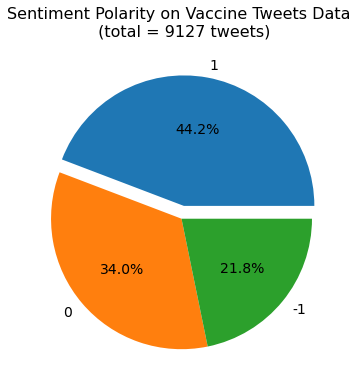

In [43]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in data['Sentiment'].value_counts()]
labels = list(data['Sentiment'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Vaccine Tweets Data \n (total = 9127 tweets)', fontsize = 16, pad = 20)
plt.show()



In [44]:
neutral = data[data['Sentiment'] == 0]
positive = data[data['Sentiment'] == 1]
negative = data[data['Sentiment'] == -1]

In [45]:
negative.iloc[1]

tweet             all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs
retweets_count    0                                                                                                                                    
Sentiment         -1                                                                                                                                   
Source            random_user                                                                                                                          
Length            133                                                                                                                                  
Word_counts       19                                                                                                                                   
Clean tweet       all the vaccines have terrible product branding and the manufacturers 

In [46]:
#neutral_text
print("Neutral tweet example  :",neutral['tweet'].values[15])
# Positive tweet
print("Positive Tweet example :",positive['tweet'].values[37])
#negative_text
print("Negative Tweet example :",negative['tweet'].values[1])

Neutral tweet example  : Israel's COVID-19 vaccine boosters show signs of taming Delta  https://t.co/hpmx4A7ui5
Positive Tweet example : This infographic visualizes how effective 14 vaccines have been (polio, diphtheria, measles, etc.) in the United States since their creation  https://t.co/NjGFrNrNfp
Negative Tweet example : all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs


> # **Neutral tweet example**  : Israel's COVID-19 vaccine boosters show signs of taming Delta  https://t.co/hpmx4A7ui5

> # **Positive Tweet example** : This infographic visualizes how effective 14 vaccines have been (polio, diphtheria, measles, etc.) in the United States since their creation  https://t.co/NjGFrNrNfp

> # **Negative Tweet example** : all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs


In [47]:
x = data.Length.values


fig = go.Figure(data=[go.Histogram(x=x,
                                   marker_line_width=1, 
                                   marker_line_color="midnightblue", 
                                   xbins_size = 5)])

fig.update_layout(title_text='Distribution of tweet lengths')
fig.show()



In [48]:
x1 = neutral.Length.values
x2 = positive.Length.values
x3 = negative.Length.values

fig = go.Figure(data=[go.Histogram(x=x1,
                                   marker_line_width=1, 
                                   marker_line_color="midnightblue", 
                                   xbins_size = 5,
                                   opacity = 0.5)])

fig.update_layout(title_text='Distribution of neutral tweet lengths')
fig.show()

fig = go.Figure(data=[go.Histogram(x=x2,
                                   marker_line_width=1, 
                                   marker_color='rgb(50,202,50)', 
                                   marker_line_color="midnightblue", 
                                   xbins_size = 5,
                                   opacity = 0.5)])

fig.update_layout(title_text='Distribution of positive tweet lengths')
fig.show()

fig = go.Figure(data=[go.Histogram(x=x3,
                                   marker_line_width=1, 
                                   marker_color='crimson', 
                                   marker_line_color="midnightblue", 
                                   opacity = 0.5)])

fig.update_layout(title_text='Distribution of negative tweet lengths')
fig.show()


In [49]:
y1 = neutral.Length.values
y2 = positive.Length.values
y3 = negative.Length.values

fig = go.Figure()

fig.add_trace(go.Box(y=y1, 
                     name="Neutral", 
                     marker_line_width=1, 
                     marker_line_color="midnightblue"))

fig.add_trace(go.Box(y=y2, 
                     name="Positive", 
                     marker_line_width=1, 
                     marker_color = 'rgb(50,202,50)'))

fig.add_trace(go.Box(y=y3, 
                     name="Negative", 
                     marker_line_width=1, 
                     marker_color = 'crimson'))

fig.update_layout(title_text="Box Plot tweet lengths")

fig.show()

In [50]:
neutral

,tweet,retweets_count,Sentiment,Source,Length,Word_counts,Clean tweet
1,"Joe Biden Urges Private Businesses to ‘Step Up with Vaccine Requirements,’ Ignores Afghanistan Crisis https://t.co/vfturjCx4s",0,0,random_user,126,15,"joe biden urges private businesses to ‘step up with vaccine requirements,’ ignores afghanistan crisis vfturjcx4s"
5,@James_Townsend9 Why did they stop post-mortems and the histopathologists ability to discover the mechanisms of covid and vaccine deaths?,0,0,random_user,137,19,why did they stop post-mortems and the histopathologists ability to discover the mechanisms of covid and vaccine deaths?
6,@nuriyliamalek Itulah. Tiba2. T rkejut tgk dia update. 😭,0,0,random_user,56,9,itulah. tiba2. t rkejut tgk dia update.
10,"https://t.co/NyTVdkPYIL Pr Henri Joyeux : ""Je vaccine des gens parce qu'ils ont la trouille"".",0,0,random_user,94,14,"nytvdkpyil pr henri joyeux : ""je vaccine des gens parce qu'ils ont la trouille""."
13,@porn_sex_xxx_20 crnremk,0,0,random_user,24,2,crnremk
...,...,...,...,...,...,...,...
9107,@JeremyCoxx @tahoeadams @AZSenateGOP @FannKfann Are you talking about the three vaccines that were approved for emergency use here in the United States? One of which (gasp) was just approved for use officially by the FDA.,0,0,random_user,221,35,are you talking about the three vaccines that were approved for emergency use here in the united states? one of which (gasp) was just approved for use officially by the fda.
9110,@itisheathertime @Kati_Kleber does the vaccine prevent one from being infected or spreading covid19? are there side effects? if so what are they?,0,0,random_user,146,22,does the vaccine prevent one from being infected or spreading covid19? are there side effects? if so what are they?
9112,mfs who eat @McDonalds needa stop commenting on the vaccine! 💯🥴😭,0,0,random_user,64,11,mfs who eat needa stop commenting on the vaccine! 🥴
9114,"@FPWellman @Facebook Facebook has increased the amount of kooky anti vaccine memes again, but God forbid you be “political”. Z man didn’t like getting told off by Joe.",0,0,random_user,167,28,"facebook has increased the amount of kooky anti vaccine memes again, but god forbid you be “political”. z man didn’t like getting told off by joe."


In [51]:
'''
def wordcloud(df, text = 'Clean tweet'):
    
    # Join all tweets in one string
    corpus = " ".join(str(review) for review in df[text])
    
    print (f"There are {len(corpus)} words in the combination of all review.")
    
    wordcloud = WordCloud(max_font_size=50, 
                          max_words=100, 
                          collocations=False,
                          background_color="white").generate(corpus)
    
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
'''



'\ndef wordcloud(df, text = \'Clean tweet\'):\n    \n    # Join all tweets in one string\n    corpus = " ".join(str(review) for review in df[text])\n    \n    print (f"There are {len(corpus)} words in the combination of all review.")\n    \n    wordcloud = WordCloud(max_font_size=50, \n                          max_words=100, \n                          collocations=False,\n                          background_color="white").generate(corpus)\n    \n    plt.figure(figsize=(15,15))\n    plt.imshow(wordcloud, interpolation="bilinear")\n    plt.axis("off")\n    plt.show()\n    \n'

In [52]:
'''
print('Neutral Wordcloud')
wordcloud(df = neutral)

print('Positive Wordcloud')
wordcloud(df = positive)

print('Negative Wordcloud')
wordcloud(df = negative)

'''



"\nprint('Neutral Wordcloud')\nwordcloud(df = neutral)\n\nprint('Positive Wordcloud')\nwordcloud(df = positive)\n\nprint('Negative Wordcloud')\nwordcloud(df = negative)\n\n"

In [53]:
data

,tweet,retweets_count,Sentiment,Source,Length,Word_counts,Clean tweet
0,#IndiaFightsCorona: ✅58.89 crore vaccine doses administered so far ✅Testing capacity substantially ramped up - 50.93 crore tests conducted so far #We4Vaccine #LargestVaccinationDrive #Unite2FightCorona Details: https://t.co/6kTcmX3APi https://t.co/fzETtgQ0U9,0,1,random_user,265,26,#indiafightscorona: ✅58.89 crore vaccine doses administered so far ✅testing capacity substantially ramped up - 50.93 crore tests conducted so far #we4vaccine #largestvaccinationdrive #unite2fightcorona details: 6ktcmx3api fzettgq0u9
1,"Joe Biden Urges Private Businesses to ‘Step Up with Vaccine Requirements,’ Ignores Afghanistan Crisis https://t.co/vfturjCx4s",0,0,random_user,126,15,"joe biden urges private businesses to ‘step up with vaccine requirements,’ ignores afghanistan crisis vfturjcx4s"
2,The flu vaccine for kids was stopped immediately following 1 serious adverse reaction. So we ARE NOT following usual Australian Standard practice for vaccines! #DoNotComply #HoldTheFuckingLine,0,-1,random_user,194,26,the flu vaccine for kids was stopped immediately following 1 serious adverse reaction. so we are not following usual australian standard practice for vaccines! #donotcomply #holdthefuckingline
3,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs,0,-1,random_user,133,19,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs
4,"@Viscous_cree @Zinj @EclecticRadical @kenklippenstein @bethbourdon Okay, vaccines are better but that means we can't even discuss Ivermectin?",0,1,random_user,141,17,"okay, vaccines are better but that means we can't even discuss ivermectin?"
...,...,...,...,...,...,...,...
9122,@Joltao Yeah that's scary bc recently they've been saying for the mRNA vaccines a third dose is needed for them to work in people taking immunosuppressants properly,0,-1,random_user,164,27,yeah that's scary bc recently they've been saying for the mrna vaccines a third dose is needed for them to work in people taking immunosuppressants properly
9123,@WulanUakie This fever is a side effect of the vaccine. I'm feeling much better now. Thank you for worrying about me.☺️,0,1,random_user,119,21,this fever is a side effect of the vaccine. i'm feeling much better now. thank you for worrying about me.☺️
9124,"@Sammysgranny @clairecmc The JC Jokers have such an impact on our lives. Refusal of mask/vaccine mandates, refusing medicaid expansion for years, cutting COVID unemployment just as it appears we will be getting hit by another wave. MO schools started today &amp; Labor Day is less than 2 weeks away.",0,-1,random_user,299,49,"the jc jokers have such an impact on our lives. refusal of mask/vaccine mandates, refusing medicaid expansion for years, cutting covid unemployment just as it appears we will be getting hit by another wave. mo schools started today &amp; labor day is less than 2 weeks away."
9125,"@RealMattCouch @BDCarmel1 1st vaccine using m(essenger)RNA. HS Bio, twisting ladder💡Ahh. Genetic sequencing, teaches body what cells to attack. Science used for chemotherapy, previously untreatable cancers. Chinese scientists released the Covid gene sequence 1/11/20. Moderna,Pfizer+$=vaccine Invesigate🙏",0,-1,random_user,304,35,"1st vaccine using m(essenger)rna. hs bio, twisting ladderahh. genetic sequencing, teaches body what cells to attack. science used for chemotherapy, previously untreatable cancers. chinese scientists released the covid gene sequence 1/11/20. moderna,pfizer+$=vaccine invesigate"


In [54]:
data['tidy_tweet'] = data['Clean tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [55]:
data.head()

,tweet,retweets_count,Sentiment,Source,Length,Word_counts,Clean tweet,tidy_tweet
0,#IndiaFightsCorona: ✅58.89 crore vaccine doses administered so far ✅Testing capacity substantially ramped up - 50.93 crore tests conducted so far #We4Vaccine #LargestVaccinationDrive #Unite2FightCorona Details: https://t.co/6kTcmX3APi https://t.co/fzETtgQ0U9,0,1,random_user,265,26,#indiafightscorona: ✅58.89 crore vaccine doses administered so far ✅testing capacity substantially ramped up - 50.93 crore tests conducted so far #we4vaccine #largestvaccinationdrive #unite2fightcorona details: 6ktcmx3api fzettgq0u9,#indiafightscorona: ✅58.89 crore vaccine doses administered ✅testing capacity substantially ramped 50.93 crore tests conducted #we4vaccine #largestvaccinationdrive #unite2fightcorona details: 6ktcmx3api fzettgq0u9
1,"Joe Biden Urges Private Businesses to ‘Step Up with Vaccine Requirements,’ Ignores Afghanistan Crisis https://t.co/vfturjCx4s",0,0,random_user,126,15,"joe biden urges private businesses to ‘step up with vaccine requirements,’ ignores afghanistan crisis vfturjcx4s","biden urges private businesses ‘step with vaccine requirements,’ ignores afghanistan crisis vfturjcx4s"
2,The flu vaccine for kids was stopped immediately following 1 serious adverse reaction. So we ARE NOT following usual Australian Standard practice for vaccines! #DoNotComply #HoldTheFuckingLine,0,-1,random_user,194,26,the flu vaccine for kids was stopped immediately following 1 serious adverse reaction. so we are not following usual australian standard practice for vaccines! #donotcomply #holdthefuckingline,vaccine kids stopped immediately following serious adverse reaction. following usual australian standard practice vaccines! #donotcomply #holdthefuckingline
3,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs,0,-1,random_user,133,19,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs,vaccines have terrible product branding manufacturers worried anti-vaccine blowback will affect their other drugs
4,"@Viscous_cree @Zinj @EclecticRadical @kenklippenstein @bethbourdon Okay, vaccines are better but that means we can't even discuss Ivermectin?",0,1,random_user,141,17,"okay, vaccines are better but that means we can't even discuss ivermectin?","okay, vaccines better that means can't even discuss ivermectin?"


In [56]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [#indiafightscorona:, ✅58.89, crore, vaccine, doses, administered, ✅testing, capacity, substantially, ramped, 50.93, crore, tests, conducted, #we4vaccine, #largestvaccinationdrive, #unite2fightcorona, details:, 6ktcmx3api, fzettgq0u9]
1    [biden, urges, private, businesses, ‘step, with, vaccine, requirements,’, ignores, afghanistan, crisis, vfturjcx4s]                                                                                                                       
2    [vaccine, kids, stopped, immediately, following, serious, adverse, reaction., following, usual, australian, standard, practice, vaccines!, #donotcomply, #holdthefuckingline]                                                             
3    [vaccines, have, terrible, product, branding, manufacturers, worried, anti-vaccine, blowback, will, affect, their, other, drugs]                                                                                                          
4    [okay,, vaccines, better, that, mea

In [57]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [#indiafightscorona:, ✅58.89, crore, vaccin, dose, administ, ✅test, capac, substanti, ramp, 50.93, crore, test, conduct, #we4vaccin, #largestvaccinationdr, #unite2fightcorona, details:, 6ktcmx3api, fzettgq0u9]
1    [biden, urg, privat, busi, ‘step, with, vaccin, requirements,’, ignor, afghanistan, crisi, vfturjcx4]                                                                                                            
2    [vaccin, kid, stop, immedi, follow, seriou, advers, reaction., follow, usual, australian, standard, practic, vaccines!, #donotcompli, #holdthefuckinglin]                                                        
3    [vaccin, have, terribl, product, brand, manufactur, worri, anti-vaccin, blowback, will, affect, their, other, drug]                                                                                              
4    [okay,, vaccin, better, that, mean, can't, even, discuss, ivermectin?]                                                                 

In [58]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

data['tidy_tweet'] = tokenized_tweet

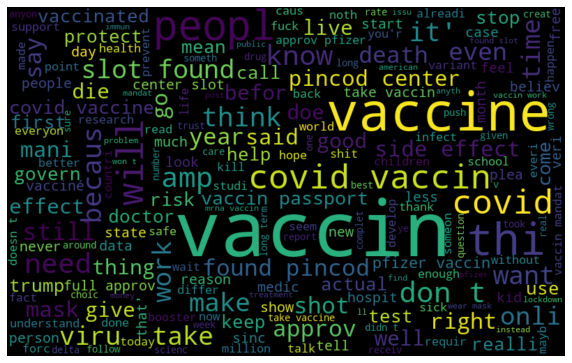

In [59]:
all_words = ' '.join([text for text in data['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [60]:
data

,tweet,retweets_count,Sentiment,Source,Length,Word_counts,Clean tweet,tidy_tweet
0,#IndiaFightsCorona: ✅58.89 crore vaccine doses administered so far ✅Testing capacity substantially ramped up - 50.93 crore tests conducted so far #We4Vaccine #LargestVaccinationDrive #Unite2FightCorona Details: https://t.co/6kTcmX3APi https://t.co/fzETtgQ0U9,0,1,random_user,265,26,#indiafightscorona: ✅58.89 crore vaccine doses administered so far ✅testing capacity substantially ramped up - 50.93 crore tests conducted so far #we4vaccine #largestvaccinationdrive #unite2fightcorona details: 6ktcmx3api fzettgq0u9,#indiafightscorona: ✅58.89 crore vaccin dose administ ✅test capac substanti ramp 50.93 crore test conduct #we4vaccin #largestvaccinationdr #unite2fightcorona details: 6ktcmx3api fzettgq0u9
1,"Joe Biden Urges Private Businesses to ‘Step Up with Vaccine Requirements,’ Ignores Afghanistan Crisis https://t.co/vfturjCx4s",0,0,random_user,126,15,"joe biden urges private businesses to ‘step up with vaccine requirements,’ ignores afghanistan crisis vfturjcx4s","biden urg privat busi ‘step with vaccin requirements,’ ignor afghanistan crisi vfturjcx4"
2,The flu vaccine for kids was stopped immediately following 1 serious adverse reaction. So we ARE NOT following usual Australian Standard practice for vaccines! #DoNotComply #HoldTheFuckingLine,0,-1,random_user,194,26,the flu vaccine for kids was stopped immediately following 1 serious adverse reaction. so we are not following usual australian standard practice for vaccines! #donotcomply #holdthefuckingline,vaccin kid stop immedi follow seriou advers reaction. follow usual australian standard practic vaccines! #donotcompli #holdthefuckinglin
3,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs,0,-1,random_user,133,19,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs,vaccin have terribl product brand manufactur worri anti-vaccin blowback will affect their other drug
4,"@Viscous_cree @Zinj @EclecticRadical @kenklippenstein @bethbourdon Okay, vaccines are better but that means we can't even discuss Ivermectin?",0,1,random_user,141,17,"okay, vaccines are better but that means we can't even discuss ivermectin?","okay, vaccin better that mean can't even discuss ivermectin?"
...,...,...,...,...,...,...,...,...
9122,@Joltao Yeah that's scary bc recently they've been saying for the mRNA vaccines a third dose is needed for them to work in people taking immunosuppressants properly,0,-1,random_user,164,27,yeah that's scary bc recently they've been saying for the mrna vaccines a third dose is needed for them to work in people taking immunosuppressants properly,yeah that' scari recent they'v been say mrna vaccin third dose need them work peopl take immunosuppress properli
9123,@WulanUakie This fever is a side effect of the vaccine. I'm feeling much better now. Thank you for worrying about me.☺️,0,1,random_user,119,21,this fever is a side effect of the vaccine. i'm feeling much better now. thank you for worrying about me.☺️,thi fever side effect vaccine. feel much better now. thank worri about me.☺️
9124,"@Sammysgranny @clairecmc The JC Jokers have such an impact on our lives. Refusal of mask/vaccine mandates, refusing medicaid expansion for years, cutting COVID unemployment just as it appears we will be getting hit by another wave. MO schools started today &amp; Labor Day is less than 2 weeks away.",0,-1,random_user,299,49,"the jc jokers have such an impact on our lives. refusal of mask/vaccine mandates, refusing medicaid expansion for years, cutting covid unemployment just as it appears we will be getting hit by another wave. mo schools started today &amp; labor day is less than 2 weeks away.","joker have such impact lives. refus mask/vaccin mandates, refus medicaid expans years, cut covid unemploy just appear will get anoth wave. school start today &

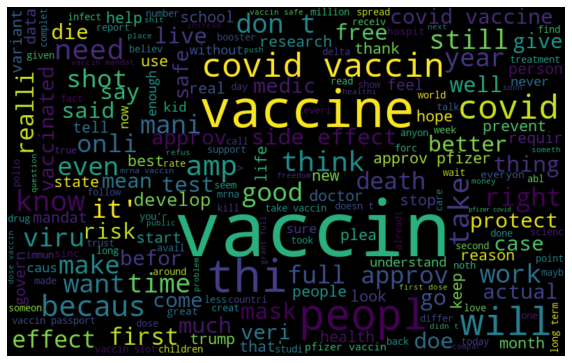

In [61]:
normal_words =' '.join([text for text in data['tidy_tweet'][data['Sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

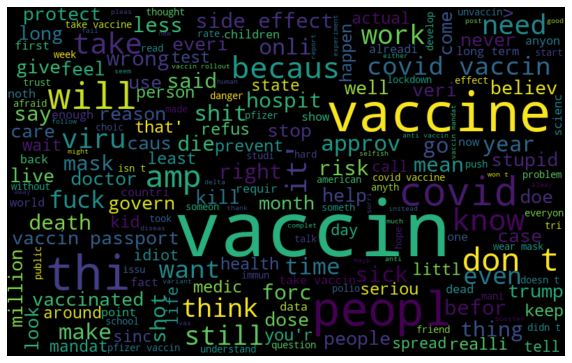

In [62]:
normal_words =' '.join([text for text in data['tidy_tweet'][data['Sentiment'] == -1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

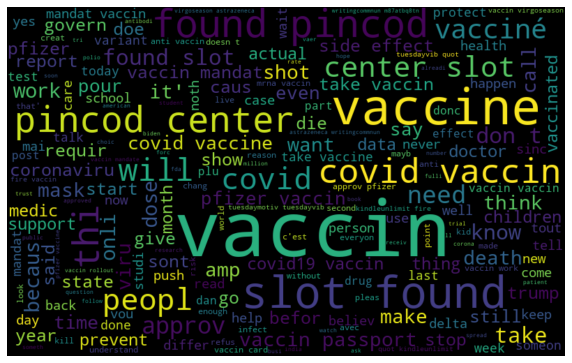

In [63]:
normal_words =' '.join([text for text in data['tidy_tweet'][data['Sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Understanding the impact of Hashtags on tweets sentiment

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments

In [64]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [65]:
# extracting hashtags from positive tweets

HT_positive = hashtag_extract(data['tweet'][data['Sentiment'] == 1])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(data['tweet'][data['Sentiment'] == -1])

# extracting hashtags from neutral tweets
HT_neutral = hashtag_extract(data['tweet'][data['Sentiment'] == 0])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])
HT_neutral = sum(HT_neutral,[])

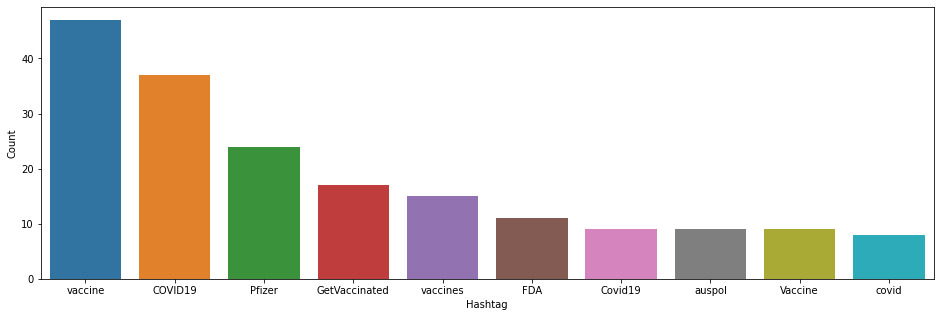

In [66]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

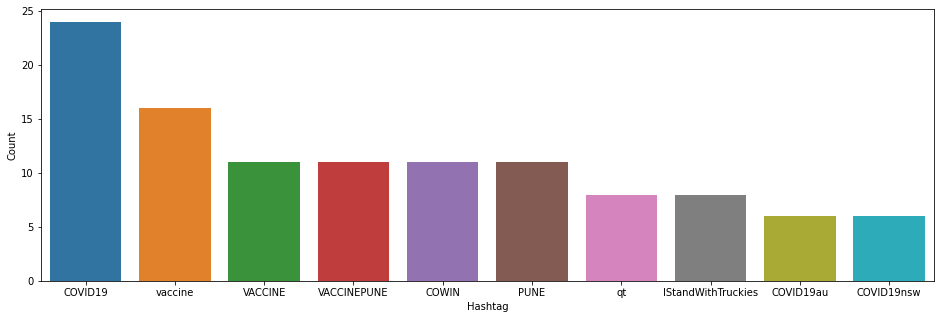

In [67]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

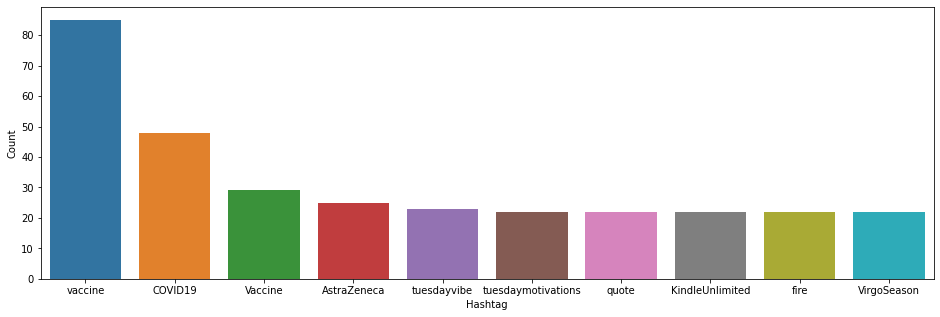

In [68]:
b = nltk.FreqDist(HT_neutral)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [69]:
data.shape

(9127, 8)

In [70]:
data.head()

,tweet,retweets_count,Sentiment,Source,Length,Word_counts,Clean tweet,tidy_tweet
0,#IndiaFightsCorona: ✅58.89 crore vaccine doses administered so far ✅Testing capacity substantially ramped up - 50.93 crore tests conducted so far #We4Vaccine #LargestVaccinationDrive #Unite2FightCorona Details: https://t.co/6kTcmX3APi https://t.co/fzETtgQ0U9,0,1,random_user,265,26,#indiafightscorona: ✅58.89 crore vaccine doses administered so far ✅testing capacity substantially ramped up - 50.93 crore tests conducted so far #we4vaccine #largestvaccinationdrive #unite2fightcorona details: 6ktcmx3api fzettgq0u9,#indiafightscorona: ✅58.89 crore vaccin dose administ ✅test capac substanti ramp 50.93 crore test conduct #we4vaccin #largestvaccinationdr #unite2fightcorona details: 6ktcmx3api fzettgq0u9
1,"Joe Biden Urges Private Businesses to ‘Step Up with Vaccine Requirements,’ Ignores Afghanistan Crisis https://t.co/vfturjCx4s",0,0,random_user,126,15,"joe biden urges private businesses to ‘step up with vaccine requirements,’ ignores afghanistan crisis vfturjcx4s","biden urg privat busi ‘step with vaccin requirements,’ ignor afghanistan crisi vfturjcx4"
2,The flu vaccine for kids was stopped immediately following 1 serious adverse reaction. So we ARE NOT following usual Australian Standard practice for vaccines! #DoNotComply #HoldTheFuckingLine,0,-1,random_user,194,26,the flu vaccine for kids was stopped immediately following 1 serious adverse reaction. so we are not following usual australian standard practice for vaccines! #donotcomply #holdthefuckingline,vaccin kid stop immedi follow seriou advers reaction. follow usual australian standard practic vaccines! #donotcompli #holdthefuckinglin
3,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs,0,-1,random_user,133,19,all the vaccines have terrible product branding and the manufacturers are worried anti-vaccine blowback will affect their other drugs,vaccin have terribl product brand manufactur worri anti-vaccin blowback will affect their other drug
4,"@Viscous_cree @Zinj @EclecticRadical @kenklippenstein @bethbourdon Okay, vaccines are better but that means we can't even discuss Ivermectin?",0,1,random_user,141,17,"okay, vaccines are better but that means we can't even discuss ivermectin?","okay, vaccin better that mean can't even discuss ivermectin?"


In [71]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = data[data['Sentiment'] == 1]
positive_tweets = positive_tweets[['tweet','Sentiment']].sort_values(by = 'Sentiment', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,tweet,Sentiment
1,#IndiaFightsCorona: ✅58.89 crore vaccine doses administered so far ✅Testing capacity substantially ramped up - 50.93 crore tests conducted so far #We4Vaccine #LargestVaccinationDrive #Unite2FightCorona Details: https://t.co/6kTcmX3APi https://t.co/fzETtgQ0U9,1
2,Trump Booed at Alabama Rally After Urging Crowd to Get COVID Vaccine I honestly think he’s losing it! 😳🤯🩴🩴 https://t.co/KfNGRVvMhy,1
3,FDA grants full approval to Pfizer-BioNTech Covid-19 vaccine #UnitedStates #Pfizer #BioNTech #Coronavirus #COVID #COVID19 #Covid_19 #CovidVaccine #FDA https://t.co/KJRPUGsA7v,1
4,"COVID-19 Vaccines: How Do We Know They Are Safe? | April 2, 2021 https://t.co/wRkNt8ks1r via @YouTube",1
5,"@btcKaz Montana also is the only state currently (I think) that has made any and all vaccine mandates illegal. Businesses, schools, etc can’t make you get it. It’s also beautiful and quiet. Seems like a good place for us to start a family.",1
6,"@Surrey_Atheist maybe if some people put more effort into effective and reliable vaccine research, rather than conspiracy theories, we wouldn’t be in this predicament! food for thought babe, you’re not that important ❤️",1
7,@themaryone1 @nandron @RockHawk @3bluegreen3 I agree. I lived in fear last year because it was so new. Now I’ll get whatever vaccines and wear a mask but still continue to live life. Wearing a mask doesn’t bother me. I’m positive I got covid in dec of 2019. But covid has made me get healthier and in shape.,1
8,"@cptwei Why did you take Pfizer in the first place? Also, US would rather sit on AZ vaccines for months than inoculate the public with it. I have no idea why Americans like you join in the hype train of dark web intellectual like Bret Weinstein to shit on mRNA vaccine",1
9,FDA Grants Full Approval To Pfizer Vaccine https://t.co/T3n97zzQ7e,1
10,"'If confirmed to be related to the vaccine, the man will be the second Australian to die after receiving a Covid-19 jab.' https://t.co/wCe79085YL",1


In [72]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = data[data['Sentiment'] == -1]
positive_tweets = positive_tweets[['tweet','Sentiment']].sort_values(by = 'Sentiment', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,tweet,Sentiment
1,The flu vaccine for kids was stopped immediately following 1 serious adverse reaction. So we ARE NOT following usual Australian Standard practice for vaccines! #DoNotComply #HoldTheFuckingLine,-1
2,@Tamzilla_52 The newer vaccines use a *portion* of a virus. Vaccine-induced immunity simply *cannot* be superior to natural immunity. The major benefit of vaccines is that they prevent death or disability that can be caused by devastating diseases such as smallpox or polio.,-1
3,"@TheJunkRocker @sebastianbach You think Gates, Zuck, Bezos, Soros, etc., etc., are conservative? Yes, some of the elites are, but none of these people are for us. And who is promoting the hell out of the vaccines? Who is profiting? Sorry if I'm not going to believe every damn thing these ppl say.",-1
4,"@govkristinoem @JoeBiden When they close our border to illegal and sick immigrants, I might think about getting the flu shot (a vaccine provides immunity).",-1
5,@dmspeech We also lined up for other vaccines.,-1
6,@CameronArlingt2 @ButterSavvy @DanS24757985 @US_FDA Cure?? You mean... The vaccine??,-1
7,Mma Maluleke sold us alcohol with soldiers roaming the streets during lockdown so this No Vaccine No Alcohol will not apply to me. 😂I Will not be forced to take the Jab https://t.co/TtnrvNRFSB,-1
8,"Was hoping to feel less angry about the unvaccinated after reading this article. Unfortunately, I'm even more pissed off. Hey, hey, selfish #antivaxxer: Your body isn't a wonderland. Get the gd vaccine. https://t.co/zhi1UpQvJx",-1
9,"@ElCanaco Legal Rights: 12 Everyone has the right not to be subjected to any cruel and unusual treatment or punishment. I would argue that preventing a healthy person (who for freedom of conscience reasons does not want the vaccine) access to work, education, public transit etc. is cruel. https://t.co/IVYhYGAVEI",-1
10,"@System_Owned @BiNGEstyles @dcbigjohn Telling a black person that you're being ""discriminated"" against because you CHOSE not to get vaccinated is just vile. I mean,.it's disgusting. It isn't discrimination, it's common sense. Get the vaccine or shut up, and be glad you have no clue what real discrimination is.",-1


In [73]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = data[data['Sentiment'] == 0]
positive_tweets = positive_tweets[['tweet','Sentiment']].sort_values(by = 'Sentiment', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,tweet,Sentiment
1,"Joe Biden Urges Private Businesses to ‘Step Up with Vaccine Requirements,’ Ignores Afghanistan Crisis https://t.co/vfturjCx4s",0
2,@CNET I mean......vaccines......masks.,0
3,Αυτοί είναι οι 4 λόγοι πίσω από την απόφαση της FDA να εγκρίνει επίσημα το εμβόλιο της Pfizer! Μετά την 3η δόση θα ακολουθήσει και 4η! https://t.co/A2Ci2F02cn #Pfizer #news #Covid_19 #vaccination #vaccine #vaccine #FDA #FDAapproved #coronavirus #COVID19 #COVID #ΕΜΒΟΛΙΑΣΜΟΙ #news,0
4,This is what happens when you get vaccinated #vaccine #FDAapproved,0
5,🟢 Another consignment of one million Sinopharm vaccine doses arrives in the country from China: Reporter https://t.co/XfIh9OGy1Z,0
6,"Catholic schools @VillanovaU and @stthomashouston gave honorary doctorates to surgeon Sr. Deirdre Byrne, who is abusing her credentials to attack COVID-19 vaccines. Sign this petition with me calling on them to rescind the degrees: https://t.co/Od4OqsWN72",0
7,"@jacindaardern just trying to wrap my head around this sh*t logic of yours This elimination thing or what ever it is youre aiming for with covid Do we just never open up as a nation to the rest of the world again? Cause your vaccines dont work So for you, where does this end?",0
8,"The S1 protein of SARS-CoV-2 crosses the blood–brain barrier in mice. 🚨Spike Protein of C0VID can cross the blood-Brain Barrier in mice like the mRNA C0VlD Vaccine.🚨 FDA approved the Pfizer mRNA Vaccine today, after thousands died of mRNA Vaccine.💥💥💥 https://t.co/FF3YFbp6Gr",0
9,"@DogRealtorAZ @DominofromAZ @Steve_Irvin @merissahamilton @galts1teaparty @misterwalkotto @cjsigmon @Garrett_Archer @brahmresnik @jeremyduda @JimSmall @NicoleSGrigg @DillonReedRose @JMShumway @morganloewcbs5 Hey @Steve_Irvin I guarantee you, there are people you and like, that won’t take the vaccine! And guess what, it is none of your business to know or inquire on anyone’s vaccine status! I don’t remember anytime I have ever been asked to show proof of any vaccinations b4 Covid!",0
10,@porn_sex_xxx_21 urpcmrk,0


# This part for scraping twitter data with twint

In [74]:
#!pip install twint

In [75]:
'''
import twint
import nest_asyncio
nest_asyncio.apply()
'''


'\nimport twint\nimport nest_asyncio\nnest_asyncio.apply()\n'

In [76]:
#!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

In [77]:
'''
c = twint.Config()
c.Search = "lockdown"
#c.Search = "vaccine"
c.Limit = 25000
c.Store_csv = True
#c.Output = 'vaccine_tweet_data.csv'
c.Output = 'lockdown_tweet_data.csv'
twint.run.Search(c)
'''


'\nc = twint.Config()\nc.Search = "lockdown"\n#c.Search = "vaccine"\nc.Limit = 25000\nc.Store_csv = True\n#c.Output = \'vaccine_tweet_data.csv\'\nc.Output = \'lockdown_tweet_data.csv\'\ntwint.run.Search(c)\n'